## **Eduardo Carrasco Vidal** <img src="img/logo.png" align="right" style="width: 120px;"/>

**Magister en Inteligencia Artificial, Universidad Adolfo Ibáñez.**

**Profesor:** Juan Bekios.
**Curso:** Aprendizaje Profundo (Deep Learning).

Enlace al repositorio del alumno en [GitHub](https://github.com/educarrascov/MIA_DeepLearning) _@educarrascov_

![Python](https://img.shields.io/badge/python-%2314354C.svg) 

# Taller 03/04: Data Augmentation, Transfer Learning y Redes Neuronales Convolucionales:

# Objetivos:

1. Entender el funcionamiento de una red convolucional, en especial, la arquitectura VGG-16.
2. Cargar los datos desde una base de datos Google Drive.
3. Crear un `Dataset` utilizando `ImageFolder`.
4. Entrenar las imágenes utilizando VGG16.
5. Aplicar los conceptos vistos en clases para entrenar una red ResNet.
6. Comparar los resultados obtenidos entre la red VGG y ResNet.
7. Proponer una red neuronal convolucional y comparar resultados.


# I. Redes Neuronales Convolucionales ("CNN"):

## 1. Cargado de librerías:

In [1]:
import torch # Cualquier librería pytorch
import torchvision # Cualquier librería pytorch
from torchvision import transforms, datasets  # Módulos para transformar imágenes a tensores y carga de dataset
import PIL # Librería para manipular imágenes en Python
import time # Librería para medir el tiempo
import copy # Librería para copiar estructuras de datos
from torch.optim import lr_scheduler # Librería para controlar el termino
import torchvision.models as models # Librería para cargar modelos de redes neuronales

## 2. Cargado de imágenes:

Se cargan las imágenes utilizando la clase **ImageFolder**. La clase ImageForder etiqueta automáticamente las imágenes dada una ruta donde se encuentran los datos. Por ejemplo, si tengo el directorio raíz dataset/training_set. Debo dejar mis imágenes de cada clase en una carpeta diferente. Si tengo imágenes de gatos debo dejarlos en dataset/training_set/cats, si tengo imágenes de perros las debo dejar en dataset/training_set/dogs, etc.

In [2]:
data_transform = transforms.Compose([
        transforms.Resize((128,128)), # Escalar la imagen
        transforms.RandomHorizontalFlip(p=0.5), #
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                scale=None, shear=None,
                                resample=False, fillcolor=0),
        transforms.ColorJitter(brightness=(1, 1.5),
                               contrast=(0.3, 2),
                               saturation=(0.2, 2),
                               hue=(-0.3, 0.3)),
        transforms.RandomRotation((-5, 5), resample=PIL.Image.BILINEAR),
        transforms.ToTensor()
    ])

gatos_perros_dataset = datasets.ImageFolder(root='3.5. Data Set/training_set',
                                           transform=data_transform)
print(gatos_perros_dataset)
dataset_loader = torch.utils.data.DataLoader(gatos_perros_dataset,
                                             batch_size=32, shuffle=False,
                                             num_workers=0)
print(dataset_loader)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: 3.5. Data Set/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               ColorJitter(brightness=(1, 1.5), contrast=(0.3, 2), saturation=(0.2, 2), hue=(-0.3, 0.3))
               RandomRotation(degrees=[-5.0, 5.0], interpolation=bilinear, expand=False, fill=0)
               ToTensor()
           )


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1420: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1435: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  warnings.warn(
/var/folders/lg/6xllmg393z39__f392znxj000000gn/T/ipykernel_60298/4131864269.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomRotation((-5, 5), resample=PIL.Image.BILINEAR),
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be r

## 3. Visualización de imágenes cargadas:

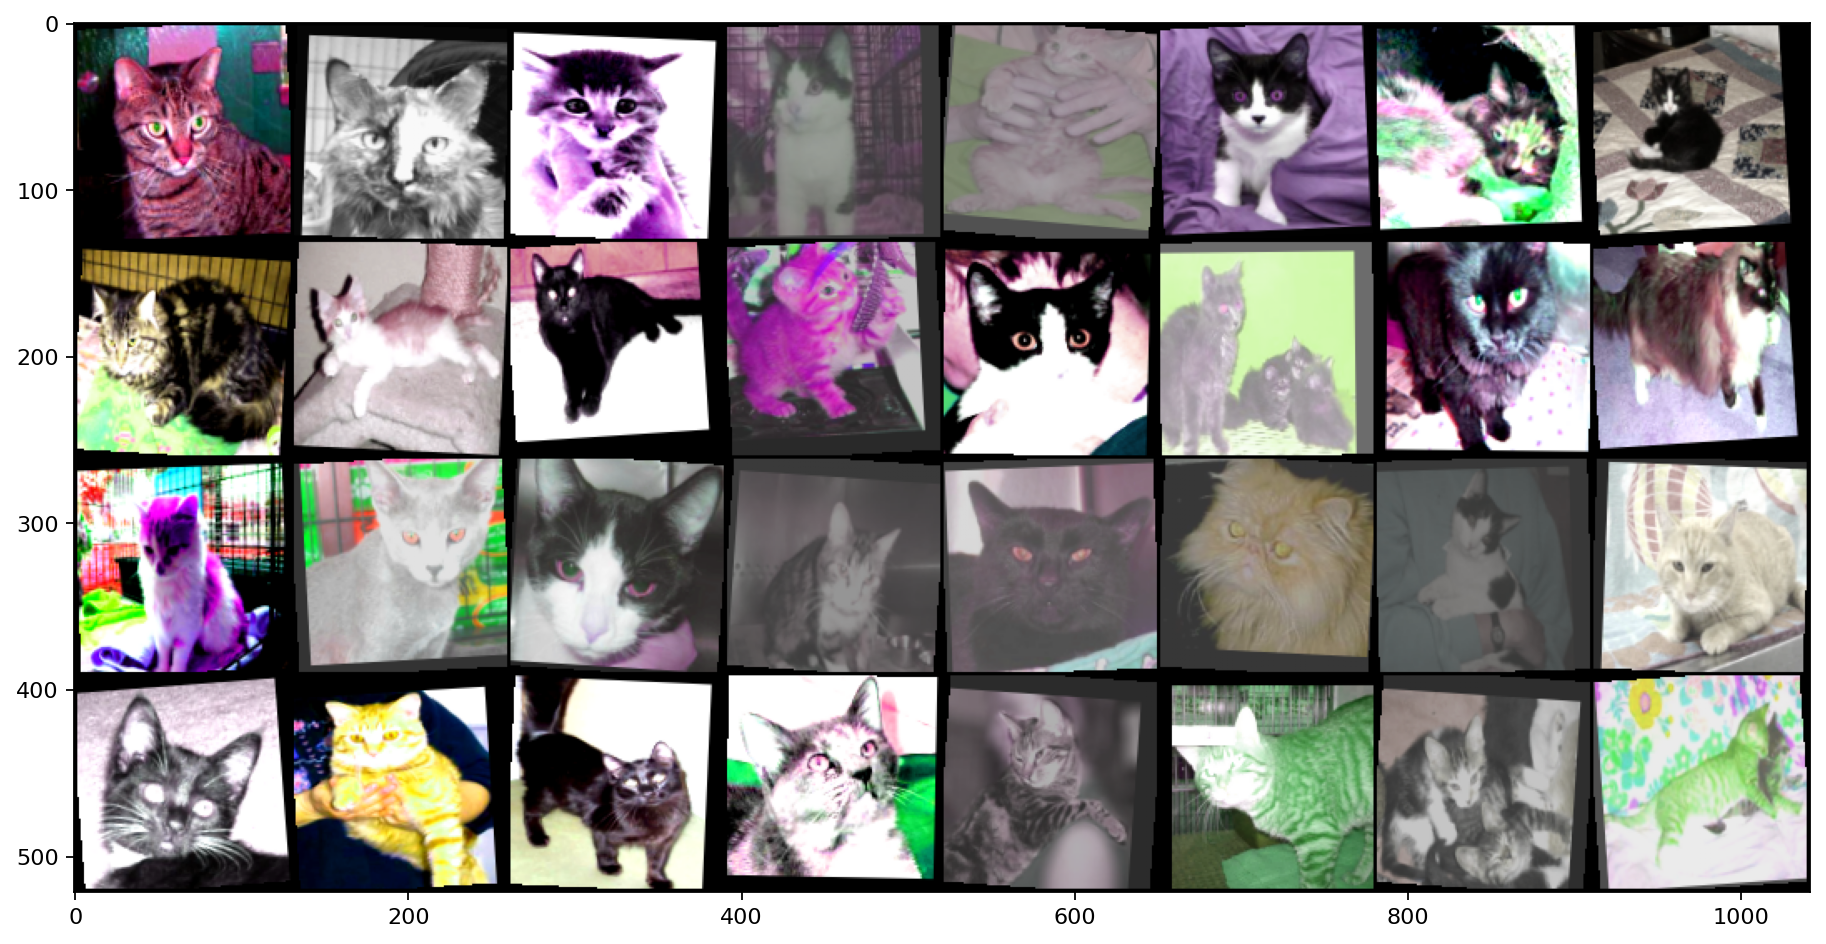

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(dataset_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 4. Separación de la base de datos:

Para realizar **el entrenamiento y pruebas** se recomienda separar los datos en tres conjuntos:

* **Conjunto de entrenamiento:** El modelo aprende de los ejemplos de este conjunto de datos. Se ajusta un parámetro a un clasificador.
* **Conjunto de validación:** Los ejemplos en el conjunto de datos de validación se utilizan para ajustar los hiperparámetros, como la tasa de aprendizaje y las épocas. El objetivo de crear un conjunto de validación es evitar un sobreajuste grande del modelo. Es un punto de control para saber si el modelo se ajusta bien con el conjunto de datos de entrenamiento.
* **Conjunto de pruebas:** Este conjunto de datos prueba la evaluación final del modelo, midiendo qué tan bien aprendió y predijo el resultado deseado. Contiene datos invisibles de la vida real. Es un conjunto diferente al de entrenamiento y validación.

Imagen: [https://i.imgur.com/DV80uhS.png](https://i.imgur.com/DV80uhS.png)

In [5]:
# Transformaciones sobre las imágenes
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='3.5. Data Set/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='3.5. Data Set/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='3.5. Data Set/test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

### 4.1. Revisión de nuevas imagenes cargadas:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


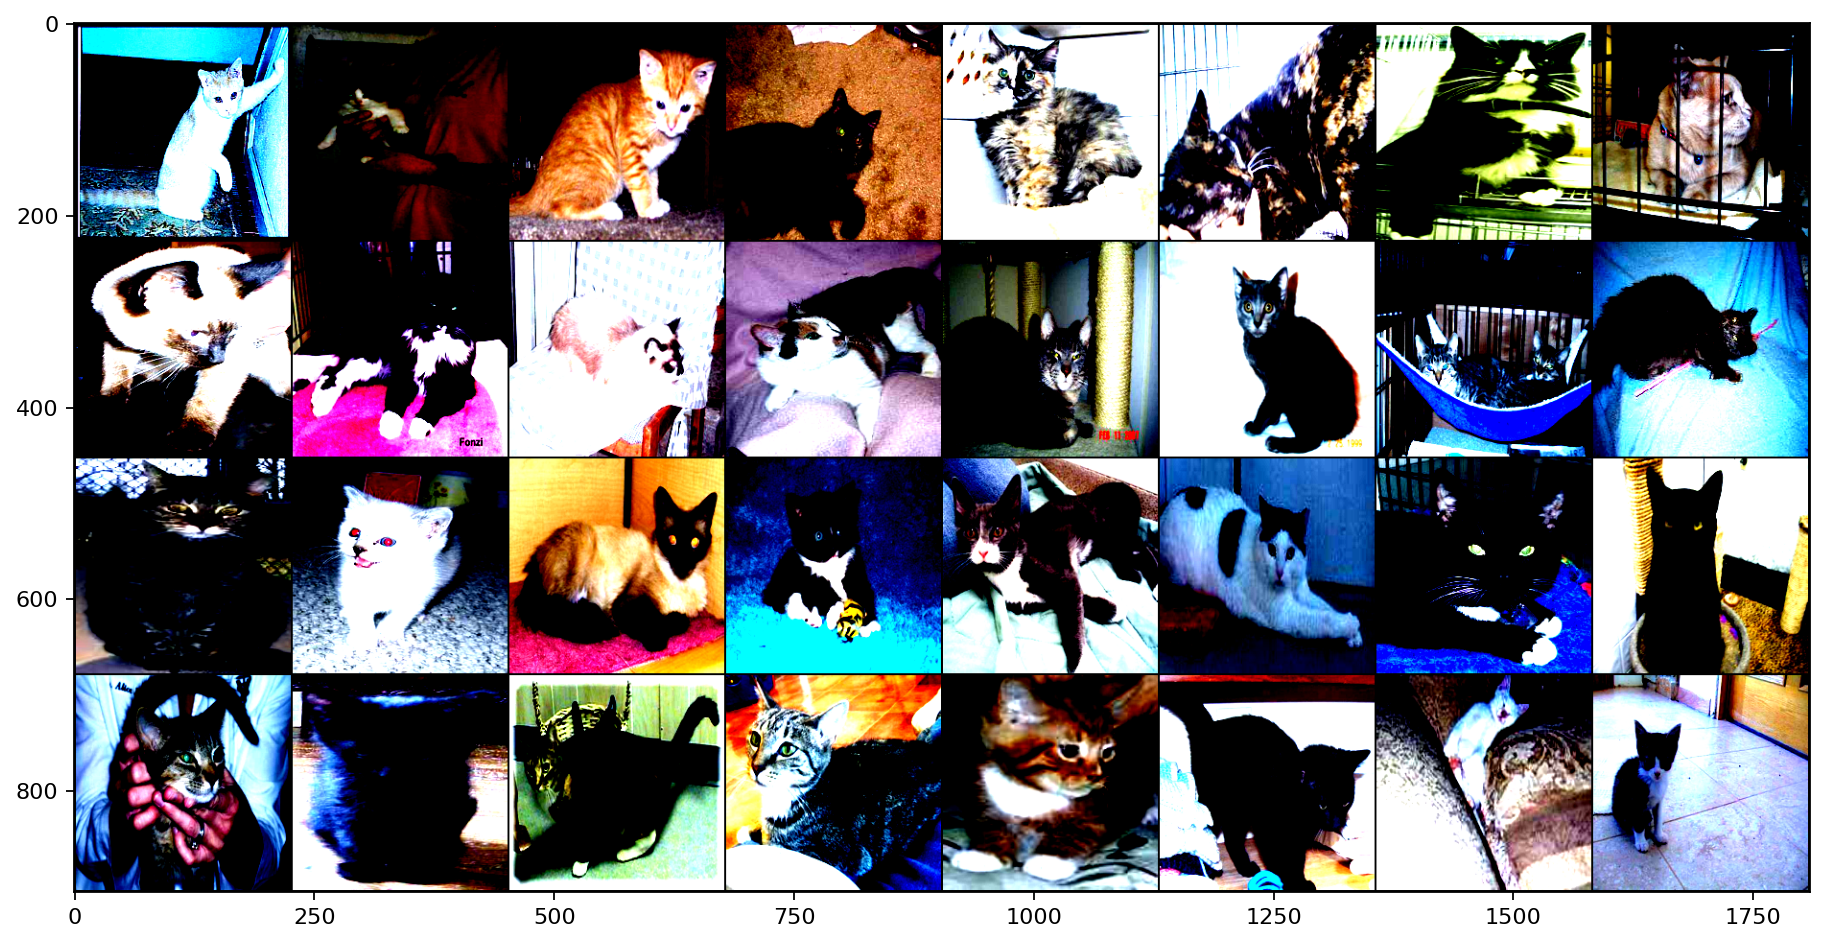

In [49]:
plt.figure(num=None, figsize=(14,9), dpi=80, facecolor='w', edgecolor='k')

# Obtener imagenes
data_iter = iter(test_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 5. Construcción del modelo (Red Neuronal Convolucional "CNN"):

Construimos un modelo con dos capas convolucionales, un dropout y dos capas completamente (_"Fully Connected"_) conectadas para la clasificación.

* Imagen red: [https://i.imgur.com/wiP9IwZ.png](https://i.imgur.com/wiP9IwZ.png)
* Imagen Conv: https://i.imgur.com/E9GGJMJ.gif
* Imagen Pool: https://i.imgur.com/kSwID7J.png

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3) #kernel por defecto es 3, canales de entrada 3 y salida 10.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3) #capa conv 2
        self.conv2_drop = nn.Dropout2d() # dropout
        self.fc1 = nn.Linear(720, 1024) #FC1
        self.fc2 = nn.Linear(1024, 2) #FC2

    def forward(self, x): # Calcular la predicción
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #F.activación
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### 5.1. Creamos el modelo de Red Neuronal Convolucional:

In [11]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


## 6. Optimización del modelo:

Seleccionamos cualquier algoritmo optimizador disponible en el paquete `torch.optim`. En general, los optimizadores son modificaciones del descenso del gradiente. _Cambiando los parámetros del modelo, como los pesos, y añadiendo sesgo, el modelo puede ser optimizado_. La **tasa de aprendizaje** decidirá cuán grandes deben ser los pasos para cambiar los parámetros.

* Calcular lo que un pequeño cambio en cada peso haría a la función de pérdida (seleccionando la dirección para alcanzar los mínimos).
* Ajustar cada peso en función de su gradiente (es decir, dar un pequeño paso en la dirección determinada).
* Continúe haciendo los pasos 1 y 2 hasta que la función de pérdida sea lo más baja posible.

Aquí, la estimación del momento adaptativo (*adaptive moment estimation* - Adam) se utiliza como un optimizador. Es una mezcla de **RMSprop** y **descenso de gradiente estocástico**.

### 6.1. Configuración de Hyperparámetros:

In [13]:
# Hyper parameters
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.01

### 6.2. Configuración del dispositivo:

Recordar que con librería 'Pytorch', Macbook con chip M1 no permite usar GPU, arrojando por defecto CPU.

In [18]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #restricciones para usar GPU por chipset m1 de Macbook.
device #debería arrijar por defecto CPU al no compatible con cuda.

device(type='cpu')

### 6.3. Optimizador:

In [19]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

## 7. Entrenamiento:

In [20]:
#%%timeit

# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.693786 	Validation Loss: 0.686847
Epoch: 2 	Training Loss: 0.688801 	Validation Loss: 0.681850
Epoch: 3 	Training Loss: 0.681487 	Validation Loss: 0.675204
Epoch: 4 	Training Loss: 0.678247 	Validation Loss: 0.668390
Epoch: 5 	Training Loss: 0.671427 	Validation Loss: 0.665079
Epoch: 6 	Training Loss: 0.667225 	Validation Loss: 0.657807
Epoch: 7 	Training Loss: 0.662243 	Validation Loss: 0.650966
Epoch: 8 	Training Loss: 0.658013 	Validation Loss: 0.641299
Epoch: 9 	Training Loss: 0.650587 	Validation Loss: 0.639443
Epoch: 10 	Training Loss: 0.646523 	Validation Loss: 0.627640
Epoch: 11 	Training Loss: 0.638476 	Validation Loss: 0.622501
Epoch: 12 	Training Loss: 0.638048 	Validation Loss: 0.630728
Epoch: 13 	Training Loss: 0.633296 	Validation Loss: 0.613585
Epoch: 14 	Training Loss: 0.625949 	Validation Loss: 0.608799
Epoch: 15 	Training Loss: 0.624579 	Validation Loss: 0.606204
Epoch: 16 	Training Loss: 0.621153 	Validation Loss: 0.604545
Epoch: 17 	Traini

### 7.1 Graficamos los resultados

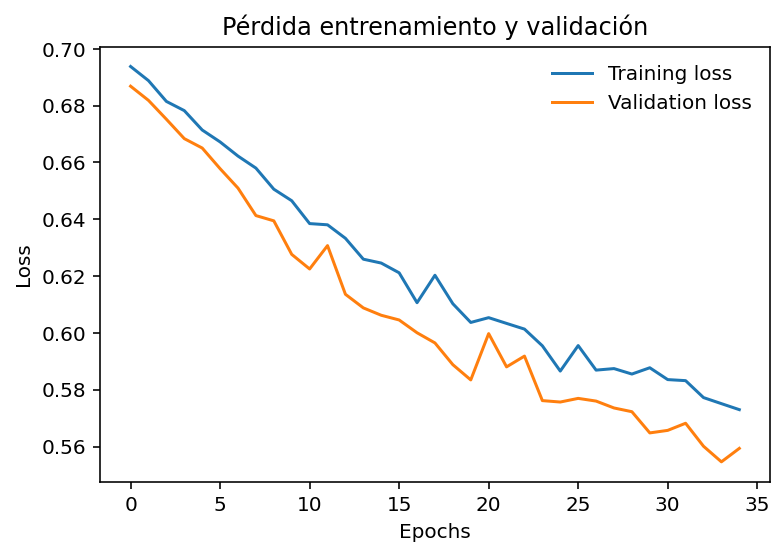

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

## 8. Tasa de Acierto del conjunto de Pruebas:

In [22]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 74.05 %


# II. Modelos pre-entrenados:

Hasta el momento hemos aprendido a configurar nuestra propia red neuronal artificial. ¿Pero estoy seguro de que la red neuronal artificial propuestas es la mejor?

Otra forma de crear modelos es utilizar modelos neuronales _probados y entrenados_.

En Python existen muchos modelos implementados:

* `VGG-16` (Y sus variaciones)
* `Resnet18 `
* Alexnet
* Squeezenet 
* Densenet 
* Inception 
* GoogLeNet 
* Shufflenet
* Mobilenet 

## 1. Arquitectura VGG16:

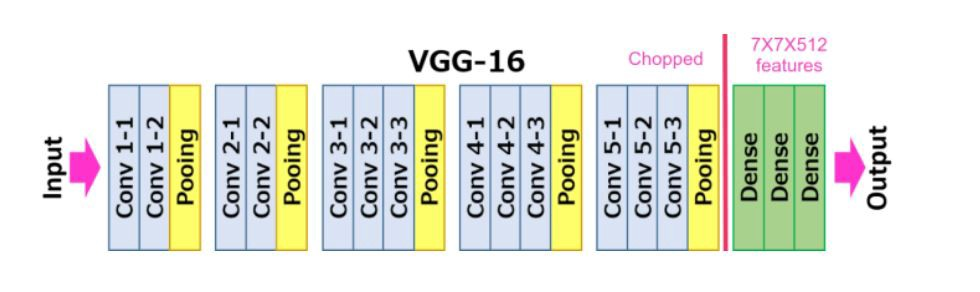

Para los experimentos de este laboratorio utilizaremos la arquitectura de red neuronal profunda `VGG-16` La cual es está compuesta por 5 grupos de capas para la extracción de características. Cada grupo de capas está compuesta de capas convolucionales y una de pooling para reducción de dimensiones.

### 1.1. Cargamos el modelo VGG-16:

Para cargar la red desde Pytorch se deben ejecutar los siguientes pasos:

In [23]:
import torch
import torchvision.models as models
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/educarrasco/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [24]:
# Mostramos el modelo cargado
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 1.2. Seleccionando la parte del modelo a utilizar:

Para utilizar el modelo pre-cargado, solo utilizamos la parte entrenada (_classifier_) donde se filtran las características. La red completamentamente conectada (fully-conected) es reemplazada para nuestro problema.

In [25]:
for parma in model_vgg16.parameters():
    parma.requires_grad = False

model_vgg16.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 1.3. Optimización:

Dejamos libre todos los pesos para que sean entrenados en la red de clasificación, utilizando la estimación del momento adaptativo (*adaptive moment estimation* - Adam) como optimizador.

In [26]:
for index, parma in enumerate(model_vgg16.classifier.parameters()):
#   if index == 6:
#       
  parma.requires_grad = True
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.classifier.parameters())

print(model_vgg16)
model_vgg16 = model_vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### 1.3.1. Revisar los parámetros correctos:

In [27]:
import torchvision.models as models 
from torchsummary import summary 

summary(model_vgg16, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

### 1.4. Entrenamiento:

#### 1.4.1. Cargar los datos:
Formación de bases de datos

In [29]:
from torchvision import transforms, datasets  # Módulos para transformar imágenes a tensores y carga de dataset
import PIL # Librería para manipular imágenes en Python

# Transformaciones sobre las imágenes
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='3.5. Data Set/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='3.5. Data Set/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='3.5. Data Set/test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

#### 1.4.2. Entrenamiento de los datos con VGG-16:

In [63]:
#%%timeit

num_epochs = 4


# keeping-track-of-losses 
train_losses_vgg16 = []
valid_losses_vgg16 = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model_vgg16.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model_vgg16(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model_vgg16.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model_vgg16(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses_vgg16.append(train_loss)
    valid_losses_vgg16.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.811861 	Validation Loss: 0.585430
Epoch: 2 	Training Loss: 0.463273 	Validation Loss: 1.486397
Epoch: 3 	Training Loss: 0.617209 	Validation Loss: 0.773936
Epoch: 4 	Training Loss: 0.571870 	Validation Loss: 1.270861


#### 1.4.3: Graficamos los resultados

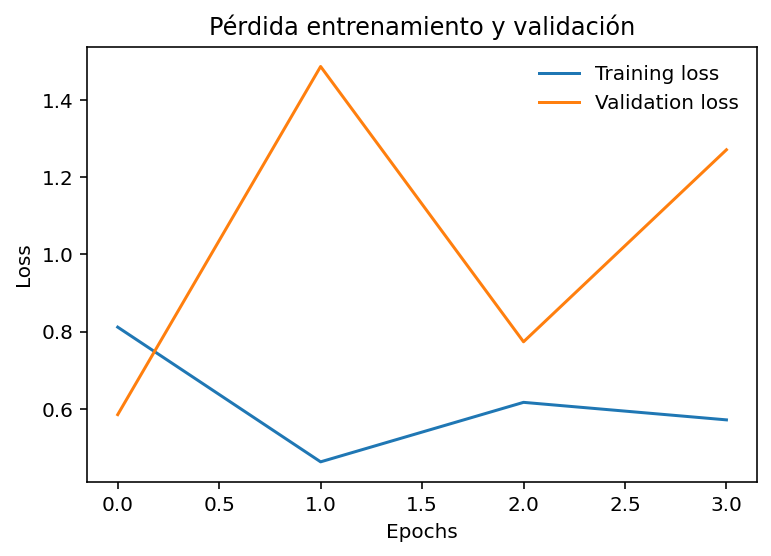

In [64]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses_vgg16, label='Training loss')
plt.plot(valid_losses_vgg16, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### 1.5. Tasa de acierto conjunto de pruebas

In [65]:
# test-the-model
model_vgg16.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model VGG-16: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model VGG-16: 98.2 %


# III. Tarea:

Implementar y resolver los objetivos 5, 6 y 7.

**Fecha de entrega:** 13 de abril del 2022.

## Objetivo 5: Aplicar los conceptos vistos en clases para entrenar una red ResNet.

### 1.1. Cargamos el modelo Resnet:

In [67]:
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet.fc = torch.nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 1.2. Verificación del modelo:

In [68]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 1.3. Optimización:

#### 1.3.1. Revisar los parámetros correctos:

In [69]:
import torchvision.models as models 
from torchsummary import summary 

summary(model_resnet.to(device), (3, 224, 224)) # Tamaño de imágenes soportado por ResNet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 1.4. Entrenamiento:

#### 1.4.1. Cargar los datos:

In [70]:
# Transformaciones sobre las imágenes
data_transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                scale=None, shear=None,
                                resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

data_transform_sin_modificar = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='3.5. Data Set/training_set',
                                           transform=data_transform_train)
gatos_perros_valid = datasets.ImageFolder(root='3.5. Data Set/valid_set',
                                           transform=data_transform_sin_modificar)
gatos_perros_test = datasets.ImageFolder(root='3.5. Data Set/test_set',
                                           transform=data_transform_sin_modificar)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)
# Diccionario que almacena el DataLoarder de entrenaminto y validación
dataloaders = {'train': train_loader,
               'val': valid_loader}
dataset_sizes = {'train': len(gatos_perros_train),
                 'val': len(gatos_perros_valid)}

#### 1.4.2. Entrenamiento de los datos con RestNet (Transfer Learning):

In [71]:
#%%timeit

num_epochs = 2


# keeping-track-of-losses 
train_losses_resnet = []
valid_losses_resnet = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model_resnet.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model_resnet(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model_resnet.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model_resnet(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses_resnet.append(train_loss)
    valid_losses_resnet.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.940587 	Validation Loss: 0.959751
Epoch: 2 	Training Loss: 0.942574 	Validation Loss: 0.966511


#### 1.4.3. Graficamos los resultados:

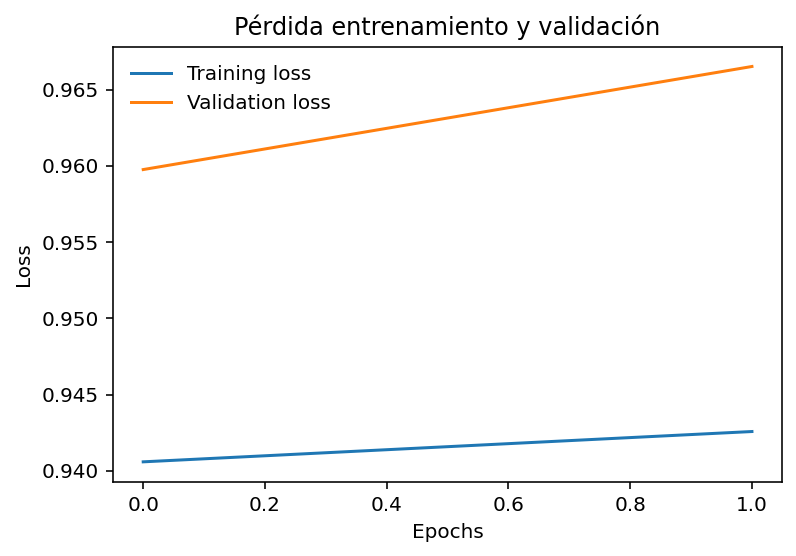

In [72]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses_resnet, label='Training loss')
plt.plot(valid_losses_resnet, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### 1.5. Tasa de Acierto conjunto de pruebas:

In [73]:
# test-the-model
model_resnet.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model Resnet: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model Resnet: 49.95 %


## Objetivo 6: Comparar los resultados obtenidos entre la red VGG y ResNet.
Objeto efectuar una comparación entre los modelos, realizaremos en primera instancia un comando para determinar su Accuracy (Con la métrica de precisión podemos medir la calidad del modelo en tareas de clasificación).

In [74]:
model_vgg16.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model VGG-16: {} %'.format(100 * correct / total))

model_resnet.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model Resnet: {} %'.format(100 * correct / total))

Test Accuracy of the model VGG-16: 98.05 %
Test Accuracy of the model Resnet: 49.95 %


De igual manera, se efectuará una comparación de ambos gráficos de pérdida (validación y entrenamiento) en función de las épocas:

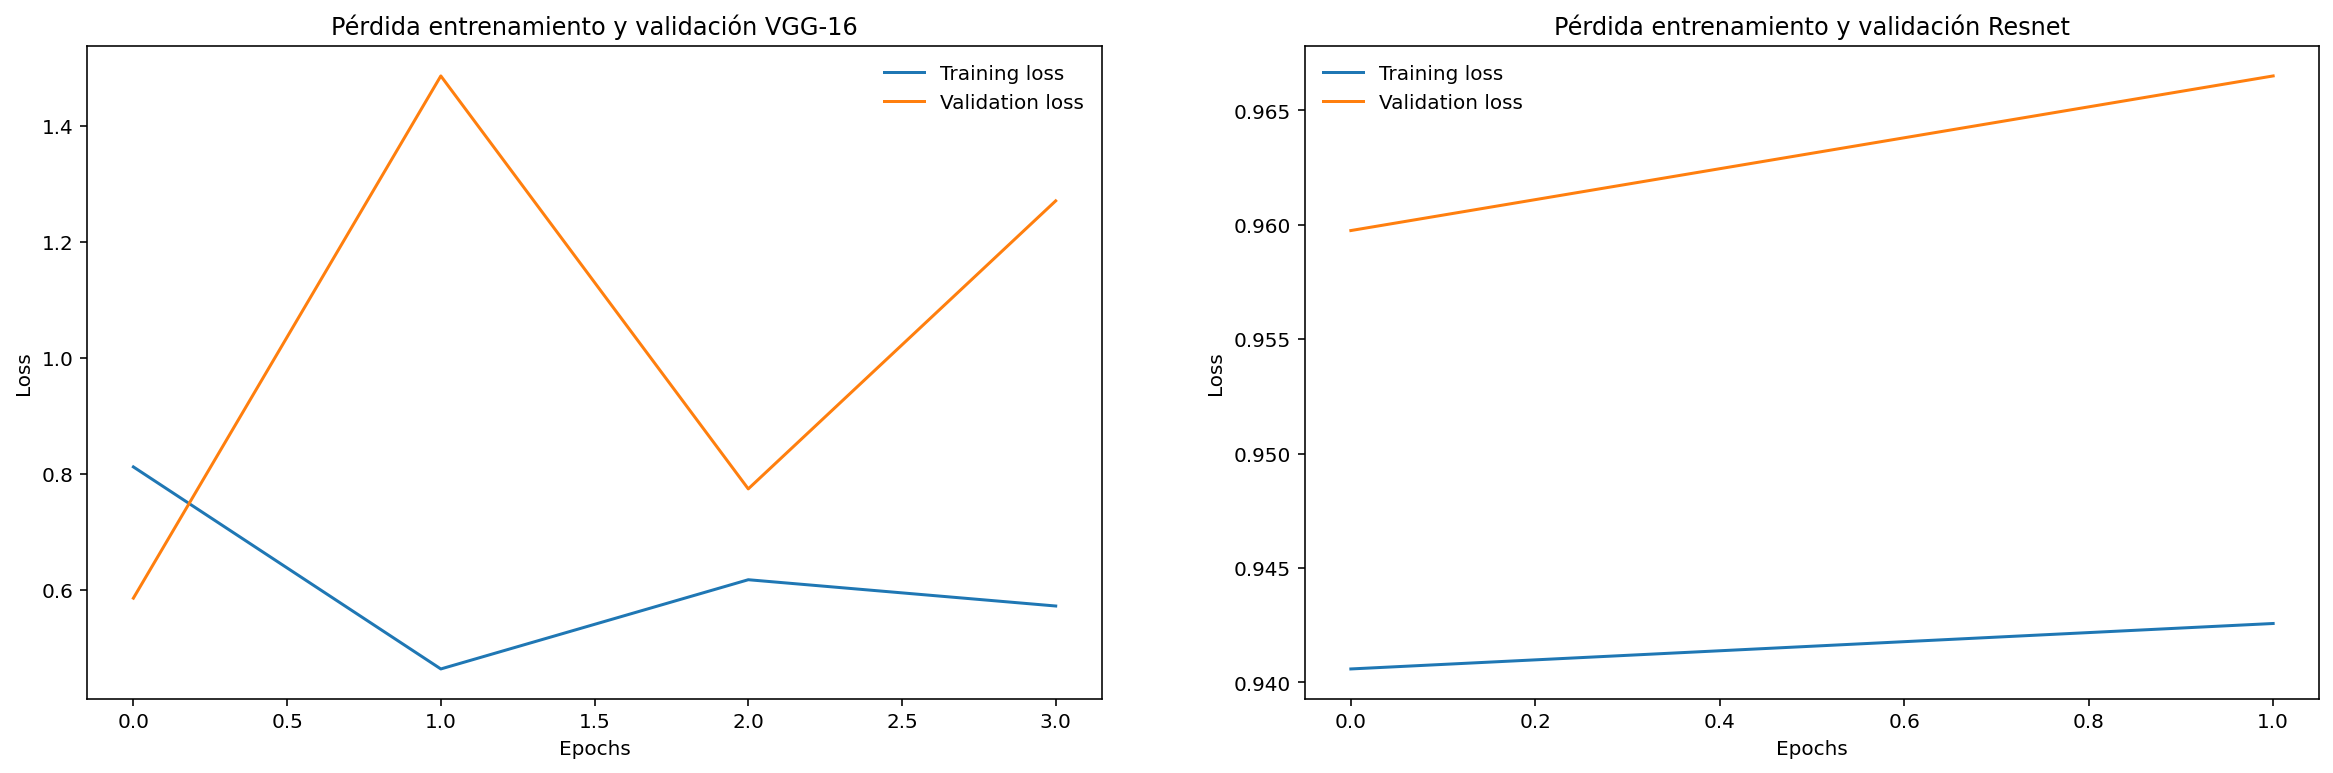

In [122]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(train_losses_vgg16, label='Training loss')
plt.plot(valid_losses_vgg16, label='Validation loss')
plt.title('Pérdida entrenamiento y validación VGG-16')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.subplot(1,2,2)
plt.plot(train_losses_resnet, label='Training loss')
plt.plot(valid_losses_resnet, label='Validation loss')
plt.title('Pérdida entrenamiento y validación Resnet')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

## Objetivo 7: Proponer una red neuronal convolucional y comparar resultados.

### 1.1. Modelo de Red Neuronal Convolucional propuesto:

Para este modelo, utilizamos los siguientes parámetros:
- 2 capas convolucionales.
- Cambio en el número de neuronas tanto de entrada como de salida.
- modificación al kernel, size 5.


In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5) #kernel por defecto es 3, canales de entrada 3 y salida 10.
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5) #capa conv 2
        self.conv2_drop = nn.Dropout2d() # dropout
        self.fc1 = nn.Linear(10*5*5, 32) #FC1
        self.fc2 = nn.Linear(32, 2) #FC2, las 2 clases que estamos trabajando

    def forward(self, x): # Calcular la predicción
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #F.activación
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

### 1.2. Verificación del modelo propuesto:

In [117]:
model_2 = CNN()
print(model_2)

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=250, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


### 1.3. Optimización:

#### 1.3.1. Revisar los parámetros correctos:

#### 1.3.2. Hiperparámetros:

In [118]:
# Hyper parameters
num_epochs = 30
num_classes = 2
batch_size = 25
learning_rate = 0.01

#### 1.3.3. Optimizador:

In [119]:
model_2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr = learning_rate)

### 1.4. Entrenamiento:

#### 1.4.1. Cargar los datos:

In [120]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='3.5. Data Set/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='3.5. Data Set/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='3.5. Data Set/test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

#### 1.4.2. Entrenamiento de los datos con la CNN Propuesta:

In [121]:
#%%timeit

# keeping-track-of-losses 
train_losses_2 = []
valid_losses_2 = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model_2.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model_2(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model_2.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model_2(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses_2.append(train_loss)
    valid_losses_2.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.694353 	Validation Loss: 0.691580
Epoch: 2 	Training Loss: 0.692084 	Validation Loss: 0.689591
Epoch: 3 	Training Loss: 0.690614 	Validation Loss: 0.688381
Epoch: 4 	Training Loss: 0.688721 	Validation Loss: 0.686111
Epoch: 5 	Training Loss: 0.687137 	Validation Loss: 0.684143
Epoch: 6 	Training Loss: 0.686448 	Validation Loss: 0.683135
Epoch: 7 	Training Loss: 0.683977 	Validation Loss: 0.680901
Epoch: 8 	Training Loss: 0.682236 	Validation Loss: 0.678890
Epoch: 9 	Training Loss: 0.684145 	Validation Loss: 0.678892
Epoch: 10 	Training Loss: 0.676561 	Validation Loss: 0.672229
Epoch: 11 	Training Loss: 0.673336 	Validation Loss: 0.668949
Epoch: 12 	Training Loss: 0.671526 	Validation Loss: 0.665450
Epoch: 13 	Training Loss: 0.667267 	Validation Loss: 0.663429
Epoch: 14 	Training Loss: 0.666269 	Validation Loss: 0.659813
Epoch: 15 	Training Loss: 0.664260 	Validation Loss: 0.659479
Epoch: 16 	Training Loss: 0.657593 	Validation Loss: 0.654085
Epoch: 17 	Traini

#### 1.4.3. Graficamos los resultados:

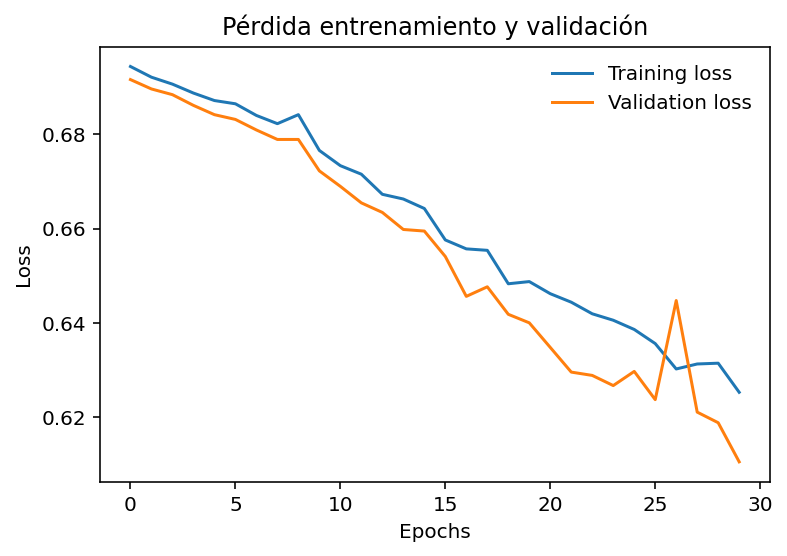

In [123]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses_2, label='Training loss')
plt.plot(valid_losses_2, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### 1.5. Tasa de Acierto del Conjunto de pruebas:

In [124]:
# test-the-model
model_2.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model CNN-2: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model CNN-2: 69.05 %


## Resultados generales

Comparar los resultados del objetivo 5, 6 y 7.

### 1. Comparación en función de curvas de aprendizaje:

**En Lineas Generales:** La pérdida (o costo) mide el error de nuestro modelo, o "lo mal que está funcionando nuestro modelo". Entonces, con el tiempo, cuanto menor sea nuestra pérdida, mejor será el rendimiento del modelo.
En definitva, si se reduce la pérdida con el tiempo, el modelo aprende.

Para este ejemplo en particular, se debe tener presente que `Trainning Loss` indica qué tan bien se ajusta el modelo a los datos de entrenamiento, mientras que la `Validation Loss` indica qué tan bien se ajusta el modelo a los datos nuevos.

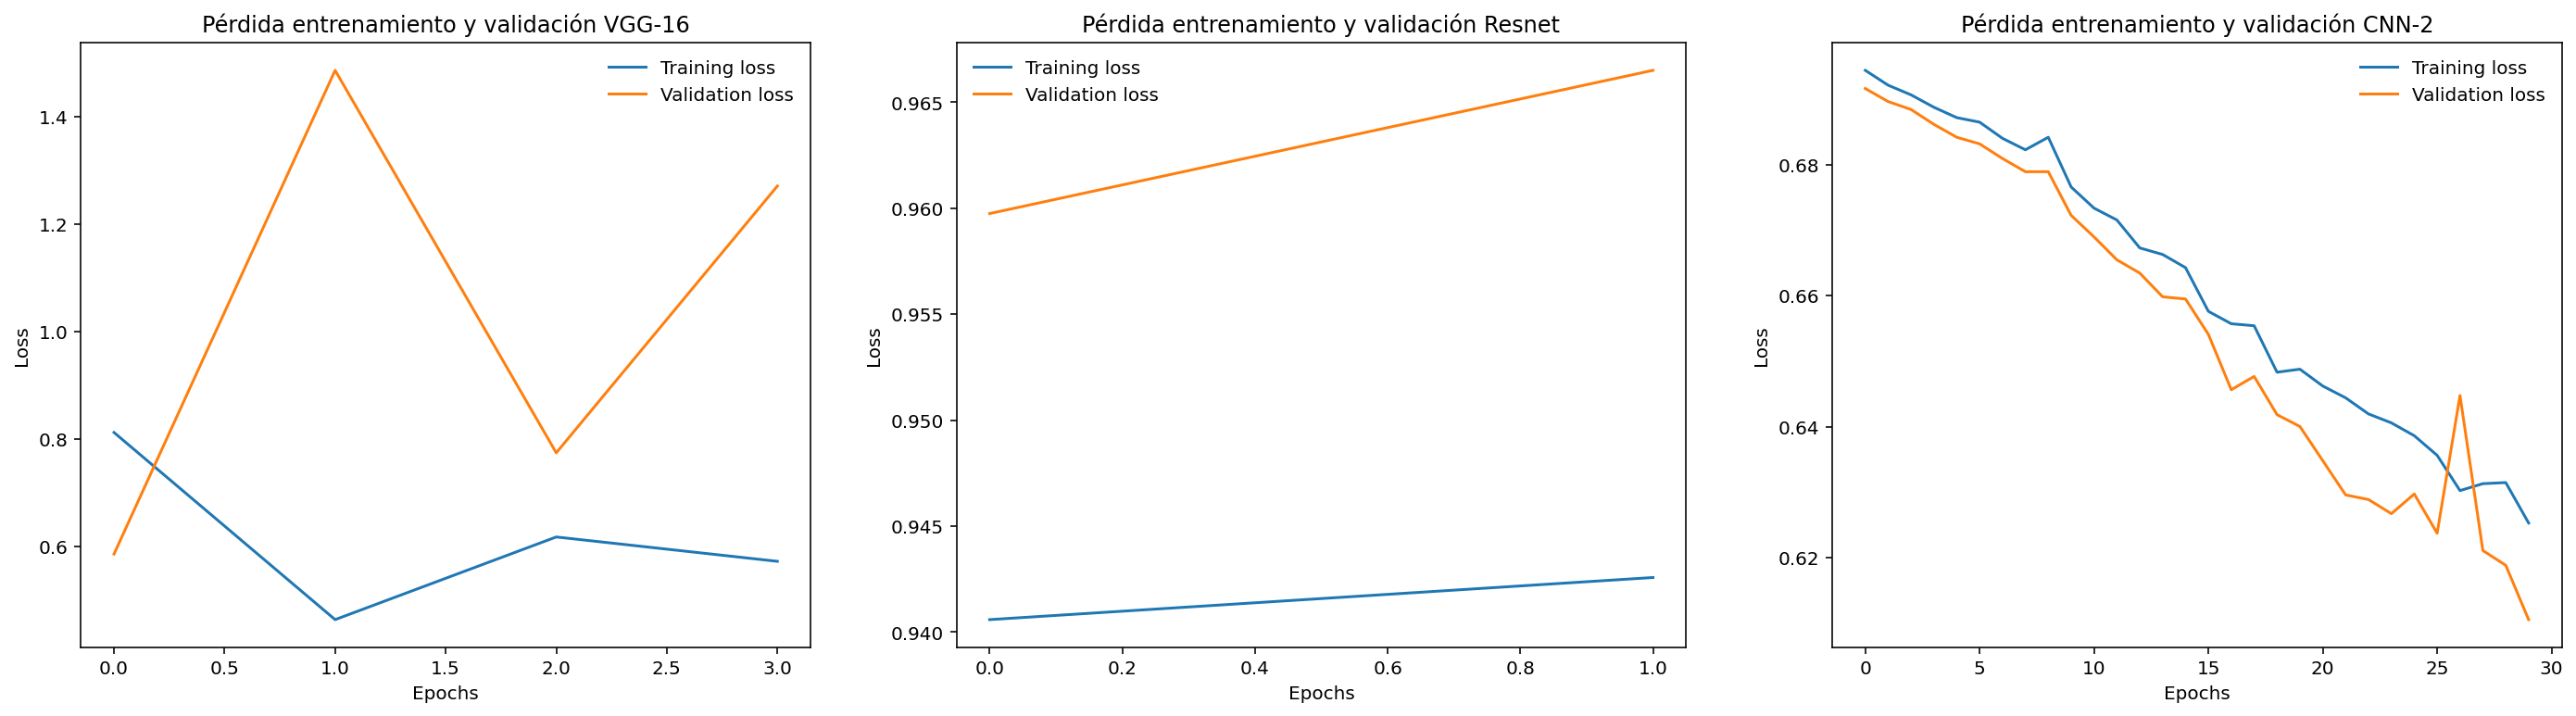

In [129]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.plot(train_losses_vgg16, label='Training loss')
plt.plot(valid_losses_vgg16, label='Validation loss')
plt.title('Pérdida entrenamiento y validación VGG-16')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.subplot(1,3,2)
plt.plot(train_losses_resnet, label='Training loss')
plt.plot(valid_losses_resnet, label='Validation loss')
plt.title('Pérdida entrenamiento y validación Resnet')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.subplot(1,3,3)
plt.plot(train_losses_2, label='Training loss')
plt.plot(valid_losses_2, label='Validation loss')
plt.title('Pérdida entrenamiento y validación CNN-2')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### 2. Comparación en función de la precisión:

La precisión es una métrica que generalmente describe el rendimiento del modelo en todas las clases. Es útil cuando todas las clases tienen la misma importancia. Se calcula como la relación entre el número de predicciones correctas y el número total de predicciones.

#### Precisión del modelo VGG-16:
Test Accuracy of the model VGG-16: 98.05 %

#### Precisión del modelo Resnet:
Test Accuracy of the model Resnet: 49.95 %

#### Precisión del modelo CNN Propuesto:
Test Accuracy of the model CNN-2: 69.05 %

#### Precisión del modelo CNN Inicial:
Test Accuracy of the model: 74.05 %

## Conclusiones

Efectuado el trabajo, podemos observar que en definitiva las redes neuronales convolucionales permiten (utilizando el kernel), ser más eficientes en la clasificación de imágenes debido a que logran identificar características que las redes convencionales no pueden lograr.
Además, se identificó que utilizar **transfer learning**, permite utilizar una propuesta de modelo, es decir, una red previamente utilizada, en la cual, ya fueron determinados su cantidad de capaz, convoluciones y neuronas; además de diversos hiperparámetros que uno puede utilizar en problemas similares.
En este caso en particular, se utilizó `VGG-16 ` y `RESNET `, las cuales permitieron facilitar el trabajo.

Como se puede observar en el resultado de las métricas, en este caso, el modelo VGG-16 es el que obtuvo la mayor precisión. Esto se refiere a que sus parámetros eran los más ajustados al problema.